# About the Competition

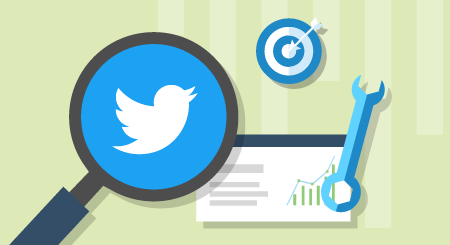


With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?

### <font color = 'red'>If you find this kernel useful please consider **upvoting it** 😊 which keeps me motivated for doing hard work and to produce more quality content.</font>

# Evaluation Metric

Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.The Jaccard Index, also known as the Jaccard similarity coefficient, is a statistic used in understanding the similarities between sample sets. The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. The mathematical representation of the index is written as:

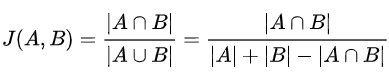

Similar to the Jaccard Index, which is a measurement of similarity, the Jaccard distance measures dissimilarity between sample sets. The Jaccard distance is calculated by finding the Jaccard index and subtracting it from 1, or alternatively dividing the differences ny the intersection of the two sets. The formula for the Jaccard distance is represented as:

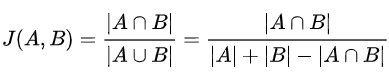

How does the Jaccard Index work?
Breaking down the formula, the Jaccard Index is essentially the number in both sets, divided by the number in either set, multiplied by 100. This will produce a percentage measurement of similarity between the two sample sets. Accordingly, to find the Jaccard distance, simply subtract the percentage value from 1. For example, if the similarity measurement is 35%, then the Jaccard distance (1 - .35) is .65 or 65%.

# Acknowledgements
1. https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model
2. https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb
3. https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-ensemble
4. https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

# Importing the relevant libraries and getting to know the files

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import re
import string
from wordcloud import WordCloud, STOPWORDS 
import spacy
from tqdm import tqdm
import os
import random
from spacy.util import compounding
from spacy.util import minibatch


import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Importing data into our kernel

In [ ]:
train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
train_df.head()

In [ ]:
print(train_df.shape)
print(test_df.shape)

# EDA

Before we jump into the EDA part, let's check if there is any missing data because it may cause a problem to us later on. 

### Check for missing values in columns

In [ ]:
train_df.info()

###  'text' and 'selected_text' both have 1 missing value. Let's have a look...


In [ ]:
print(train_df[train_df['text'].isnull()])
print(train_df[train_df['selected_text'].isnull()])

Both missing values are from the same row. So, we will just simply drop it.

In [ ]:
# drop the row with missing data
train_df.dropna(inplace = True)
# reset index and drop the index column made by reset_index()
train_df = train_df.reset_index(drop = True)

In [ ]:
train_df.info()

### Descriptive Statistics

In [ ]:
train_df.describe()

`Suprisingly, there are 17 'selected_text' values that are non-unique !

Also, we have 'good' as the most common 'selected_text' (199 times) and most of the tweet sentiments are 'neutral' (11117 tweets)

### Let's explore the 'text' and 'selected_text' columns and try to find a relationship (if any)

**NOTE : From here onwards, we will be bringing each column into consideration one by one for better understanding and Analysis of the data starting from 'text' and 'selected_text'**

In [ ]:
# Calculating no of words in each tweet in 'text' column
train_df['N_text_words'] = train_df['text'].apply(lambda tweet : len(tweet.split()))

# Calculating no of words in each tweet in 'selected_text' column
train_df['N_selected_text_words'] = train_df['selected_text'].apply(lambda tweet : len(tweet.split()))

# Calculating difference in no. of words in text and selected_text
train_df['N_words_difference'] = train_df['N_text_words'] - train_df['N_selected_text_words']

In [ ]:
train_df.head()

Lets look at the distribution of 'N_text_words' and 'N_selected_text_words' and then look the distribution of 'N_words_difference' afterwards.

In [ ]:
x1 = train_df['N_text_words']
x2 = train_df['N_selected_text_words']

group_labels = ['N_text_words', 'N_selected_text_words']

colors = ['blue', 'orange']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=1,colors=colors,show_curve = True)

# Add title
fig.update_layout(title_text='Distplot of N_text_words and N_selected_text_words')
fig.show()

In [ ]:
x1 = train_df['N_words_difference']

group_labels = ['N_words_difference']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1], group_labels, bin_size=1,show_curve = True)

# Add title
fig.update_layout(title_text='Distplot of N_words_difference')
fig.show()

The distributions here are very interesting and insightful :

In the first distribution:
* Firstly, ~ 25% of selected_text comprise only of one word which means in 25% of the tweets, only one word is responsible for determing the sentiment of the tweet
* Sencondly, the distribution is right skewed meaning number of words in most of tweets are in range 0-25

In the second distribution: 
* ~45% of the differences are 0 implying that nearly 45% of selected_text are same length as that of text and that these 45% text/selected_text are responsible for the sentiment wholely.
* The distribution is rigth skewed

## **Bringing 'sentiment' into the picture...[](http://)**

In [ ]:
# No of unique sentiments and there values
print("There are {0} unique sentiments having values {1}".format(train_df['sentiment'].nunique(), train_df['sentiment'].unique()))

In [ ]:
# Counting number of neutral sentiments 
n_neutral = train_df['sentiment'].loc[train_df['sentiment'] == 'neutral'].count()
# Counting number of positive sentiments 
n_positive = train_df['sentiment'].loc[train_df['sentiment'] == 'positive'].count()
# Counting number of negative sentiments 
n_negative = train_df['sentiment'].loc[train_df['sentiment'] == 'negative'].count()

In [ ]:
print(f"Neutral tweets : {n_neutral}")
print(f"Positive tweets : {n_positive}")
print(f"Negative tweets : {n_negative}")

Let's have a graphical visualization...

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('Sentiments',fontsize = 20)
plt.ylabel('Count',fontsize = 20)
sns.countplot(x='sentiment',data=train_df)

In [ ]:
sentiments = ['Neutral', 'Positive', 'Negative']
fig = go.Figure(data = [go.Pie(labels = sentiments, values=[n_neutral, n_positive, n_negative])])
fig.show()

In [ ]:
# breaking the dataframe sentimentwise

# dataframe with all neutral sentiments
df_neutral = train_df.loc[train_df['sentiment'] == 'neutral']
# dataframe with all positive sentiments
df_positive = train_df.loc[train_df['sentiment'] == 'positive']
# dataframe with all negative sentiments
df_negative = train_df.loc[train_df['sentiment'] == 'negative']

### Now it will be more interesting to see the distribution of sentiment with -
1. No. of words in text
2. No. of words in selected_text
3. Difference in No. of words in text and selected_text

### Distribution of No. of words in text 'N_text_words' - sentimentwise

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles = ("Neutral", "Positive", "Negative"))

fig.add_trace(
    go.Histogram(x=df_neutral["N_text_words"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_positive["N_text_words"]),
    row = 1, col = 2
)

fig.add_trace(
    go.Histogram(x=df_negative["N_text_words"]),
    row = 1, col = 3
)

fig.update_layout(title_text="Distribution of No. of words in 'text'", showlegend = False)

fig.show()

### Distribution of No. of words in selected_text 'N_selected_text_words' - sentimentwise

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles = ("Neutral", "Positive", "Negative"))

fig.add_trace(
    go.Histogram(x=df_neutral["N_selected_text_words"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_positive["N_selected_text_words"]),
    row = 1, col = 2
)

fig.add_trace(
    go.Histogram(x=df_negative["N_selected_text_words"]),
    row = 1, col = 3
)

fig.update_layout(title_text="Distribution of No. of words in 'selected_text'", showlegend = False)

fig.show()

### Distribution of difference of words 'N_words_difference' - sentimentwise

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles = ("Neutral", "Positive", "Negative"))

fig.add_trace(
    go.Histogram(x=df_neutral["N_words_difference"]),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_positive["N_words_difference"]),
    row = 1, col = 2
)

fig.add_trace(
    go.Histogram(x=df_negative["N_words_difference"]),
    row = 1, col = 3
)

fig.update_layout(title_text="Distribution of difference of words 'N_words_difference'", showlegend = False)

fig.show()

### What do the above 3 plots tell us?

**In the first distribution plot :**
All three graphs are right skewed and have most of data lying in the following range:
* Neutral sentiment tweets  - (3,12)
* Positive sentiment tweets - (4,16)
* Negative sebtiment tweets - (4,16)
   
**In the second distribution plot:**
All three graphs are right skewed but,
* Neutral graph has a high kurtosis (Leptokurtic)
* Positve and Negative graph have a peak when No. of words in selected_text = 1 and then there is a drastic decline.

**In the thrid distribution plot:**
All three graphs are right skewed and,
* Almost all **i.e 10,278/11117** selected_text are same as the text when the sentiment is Neutral.
* Positve and Negative graph have a peak when difference in No.of words = 0 following which we can see a right skewed distribution.

### The whole purpose of this competition is to find word(s) responsible for the sentiment of tweets using the word-level Jaccard Coefficient/Score as the evaluation metric

**Kaggle and competiton oraganizers were kind enough to provide us with code for computing Jaccard score. So, lets bring Jaccard score into play... **


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
jaccard_score = []
for i in range(train_df.shape[0]):
    str1 = train_df['text'][i].strip()
    str2 = train_df['selected_text'][i].strip()
    jaccard_score.append(jaccard(str1,str2))

In [ ]:
# Adding Jaccard score as a column to our training dataframe
train_df['Jaccard_score'] = jaccard_score

In [ ]:
train_df.head()

### Lets see how Jaccard Score is distributed across the dataset

In [ ]:
plt.figure(figsize = (16,6))
sns.kdeplot(train_df['Jaccard_score'], shade=True, color="r")
plt.title('Distribution of Jaccard score across the data set')

### Distribution of Jaccard Score - Sentimentwise

**I was not able to plot KDE plot for Neutral sentiments because as soon as I included it , I got an error - 'RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.' - This is because of the fact that the difference in number of words for 'text' and 'selected_text' i.e. 'N_words_difference' is mostly 0 for neutral sentiments.
**

**Do not worry, we will draw a distplot to visualize the distribution of Jaccard score for Neutral sentiments**

### Distribution of Jaccard Score for positive and negative sentiments

In [ ]:
plt.figure(figsize=(12,6))
plt1 = sns.kdeplot(train_df[train_df['sentiment'] == 'positive']['Jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
plt2 = sns.kdeplot(train_df[train_df['sentiment'] == 'negative']['Jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

### Distribution of Jaccard Score for Neutral sentiments

In [ ]:
df_neutral = train_df[train_df['sentiment'] == 'neutral']
fig = px.histogram(df_neutral, x="Jaccard_score", nbins=30)
fig.show()

# Preprocessing

Before we start with any NLP project we need to pre-process the data .We need to clean our data thouroughly, remove all stopwords and convert our data to lowercase. Let's create a helper function which will perform the following preprocessing tasks for us :
* Remove punctuations
* Remove hyperlinks
* Remove words in square brackets
* Convert text to lowercase
* Removing stopwords

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_df['text_cleaned'] = train_df['text'].apply(lambda x:clean_text(x))
train_df['selected_text_cleaned'] = train_df['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
STOPWORDS = stopwords.words('english')
def remove_stopwords(text):
    return [word for word in text.split() if word not in STOPWORDS]

In [ ]:
train_df['text_cleaned'] = train_df['text_cleaned'].apply(lambda x : remove_stopwords(x))
train_df['selected_text_cleaned'] = train_df['selected_text_cleaned'].apply(lambda x : remove_stopwords(x))

In [ ]:
train_df.head()

# Text Based Analysis

Since now we have a cleaner version of our data, it will be interesting to see some text based analysis and their visualizations like:

1. Most common words for text and selected_text.
2. Most common words - sentimentwise.
3. Word Clouds.

Let's start off with the first one.

### 1. Most common words for 'text' and 'selected_text'

To get the most common words, we first need to prepare a list of all words present in the 'text' and 'selected_text' column using the below helper function.

In [ ]:
def get_all_words(df_col):
    all_words_text = []
    for row in df_col:
        for word in row:
            all_words_text.append(word)
    return all_words_text

all_words_text = get_all_words(train_df['text_cleaned'])
all_words_selected_text = get_all_words(train_df['selected_text_cleaned'])

Since we have got our list of all words from both the columns, we can now find the most common words in both these columns and see some beautiful visualizations. 

In [ ]:
def most_common_words(all_words):
    return nltk.FreqDist(all_words)

In [ ]:
# for 'text' column
words = []
frequency = []
freqDist = most_common_words(all_words_text)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words in Text', orientation='h', 
             width=700, height=700,color=words)
fig.show()

In [ ]:
# for 'selected_text' column
words = []
frequency = []
freqDist = most_common_words(all_words_selected_text)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color=words)
fig.show()

### 2. Most common words - sentimentwise

In [ ]:
all_words_neutral = get_all_words(train_df[train_df['sentiment'] == 'neutral']['text_cleaned'])
all_words_positive = get_all_words(train_df[train_df['sentiment'] == 'positive']['text_cleaned'])
all_words_negative = get_all_words(train_df[train_df['sentiment'] == 'negative']['text_cleaned'])

In [ ]:
# for 'neutral' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_neutral)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with Neutral Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

In [ ]:
# for 'positive' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_positive)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with positive Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

In [ ]:
# for 'negative' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_negative)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with Negative Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

### 3. Word Clouds

It's time now to look at some Word Clouds. We will visualize them in the following order : 
1. WordCloud for positive sentiments.
2. WordCloud for negative sentiments.
3. WordCloud for neutral sentiments.

WordCloud will give us more clarity ont the most common words because the most common words will be shown with biggest fonts. Higher the frequency of a word, bigger will be it's font in the WordCloud. Also, WordClouds are visually more appealing.

In [ ]:
def plot_wordcloud(all_words):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)
    all_words = " ".join(all_words)
    wordcloud = WordCloud(width = 400, height = 200, 
                background_color ='white',
                max_words = 200,
                stopwords = stopwords,
                min_font_size = 10)
    wordcloud = wordcloud.generate(all_words)
    
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

#### WORDCLOUD FOR POSITIVE TWEETS

In [ ]:
plot_wordcloud(all_words_positive)

#### WORDCLOUD FOR NEGATIVE TWEETS

In [ ]:
plot_wordcloud(all_words_negative)

####  WORDCLOUD FOR NEUTRAL TWEETS

In [ ]:
plot_wordcloud(all_words_neutral)

# Modelling - Using NER

**What is NER?**

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

Here for modelling purpose, I have used NER model using SpaCy. The solution for this type of model is provided by Rohit Singh. So here, I am going to use the same model but with little tweaks.

Thanks to Rohit Singh for the amazing kernel and the solution he has provided through his kernel. Do check out his kernel using the below link and upvote it if you find it useful.

Rohit Singh's kernel on NER model training - https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-ensemble

For understanding NER here is very good article : https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

In [ ]:
# df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
# df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
# df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [ ]:
# df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [ ]:
# df_train = df_train[df_train['Num_words_text']>=3]

In [ ]:
# def save_model(output_dir, nlp, new_model_name):
#     ''' This Function Saves model to 
#     given output directory'''
    
#     output_dir = f'../working/{output_dir}'
#     if output_dir is not None:        
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)
#         nlp.meta["name"] = new_model_name
#         nlp.to_disk(output_dir)
#         print("Saved model to", output_dir)

In [ ]:
# # pass model = nlp if you want to train on top of existing model 

# def train(train_data, output_dir, n_iter=20, model=None):
#     """Load the model, set up the pipeline and train the entity recognizer."""
#     ""
#     if model is not None:
#         nlp = spacy.load(output_dir)  # load existing spaCy model
#         print("Loaded model '%s'" % model)
#     else:
#         nlp = spacy.blank("en")  # create blank Language class
#         print("Created blank 'en' model")
    
#     # create the built-in pipeline components and add them to the pipeline
#     # nlp.create_pipe works for built-ins that are registered with spaCy
#     if "ner" not in nlp.pipe_names:
#         ner = nlp.create_pipe("ner")
#         nlp.add_pipe(ner, last=True)
#     # otherwise, get it so we can add labels
#     else:
#         ner = nlp.get_pipe("ner")
    
#     # add labels
#     for _, annotations in train_data:
#         for ent in annotations.get("entities"):
#             ner.add_label(ent[2])

#     # get names of other pipes to disable them during training
#     other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
#     with nlp.disable_pipes(*other_pipes):  # only train NER
#         # sizes = compounding(1.0, 4.0, 1.001)
#         # batch up the examples using spaCy's minibatch
#         if model is None:
#             nlp.begin_training()
#         else:
#             nlp.resume_training()


#         for itn in tqdm(range(n_iter)):
#             random.shuffle(train_data)
#             batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
#             losses = {}
#             for batch in batches:
#                 texts, annotations = zip(*batch)
#                 nlp.update(texts,  # batch of texts
#                             annotations,  # batch of annotations
#                             drop=0.5,   # dropout - make it harder to memorise data
#                             losses=losses, 
#                             )
#             print("Losses", losses)
#     save_model(output_dir, nlp, 'st_ner')

In [ ]:
# def get_model_out_path(sentiment):
#     '''
#     Returns Model output path
#     '''
#     model_out_path = None
#     if sentiment == 'positive':
#         model_out_path = 'models/model_pos'
#     elif sentiment == 'negative':
#         model_out_path = 'models/model_neg'
#     return model_out_path

In [ ]:
# def get_training_data(sentiment):
#     '''
#     Returns Trainong data in the format needed to train spacy NER
#     '''
#     train_data = []
#     for index, row in df_train.iterrows():
#         if row.sentiment == sentiment:
#             selected_text = row.selected_text
#             text = row.text
#             start = text.find(selected_text)
#             end = start + len(selected_text)
#             train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
#     return train_data

### Training models for Positive, Negative and Neutral tweets¶


In [ ]:
# sentiment = 'positive'

# train_data = get_training_data(sentiment)
# model_path = get_model_out_path(sentiment)
# train(train_data, model_path, n_iter=7, model=None)

In [ ]:
# sentiment = 'negative'

# train_data = get_training_data(sentiment)
# model_path = get_model_out_path(sentiment)

# train(train_data, model_path, n_iter=7, model=None)

In [ ]:
# sentiment = 'neutral'

# train_data = get_training_data(sentiment)
# model_path = get_model_out_path(sentiment)

# train(train_data, model_path, n_iter=7, model=None)

### Predicting with the trained model

In [ ]:
# def predict_entities(text, model):
#     doc = model(text)
#     ent_array = []
#     for ent in doc.ents:
#         start = text.find(ent.text)
#         end = start + len(ent.text)
#         new_int = [start, end, ent.label_]
#         if new_int not in ent_array:
#             ent_array.append([start, end, ent.label_])
#     selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
#     return selected_text

In [ ]:
# selected_texts = []
# MODELS_BASE_PATH = '../input/tse-spacy-model/models/'

# if MODELS_BASE_PATH is not None:
#     print("Loading Models  from ", MODELS_BASE_PATH)
#     model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
#     model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
#     for index, row in df_test.iterrows():
#         text = row.text
#         output_str = ""
#         if row.sentiment == 'neutral' or len(text.split()) <= 2:
#             selected_texts.append(text)
#         elif row.sentiment == 'positive':
#             selected_texts.append(predict_entities(text, model_pos))
#         else:
#             selected_texts.append(predict_entities(text, model_neg))
        
# df_test['selected_text'] = selected_texts

### Creating the file for submission

In [ ]:
# df_submission['selected_text'] = df_test['selected_text']
# df_submission.to_csv("submission.csv", index=False)
# display(df_submission.head(10))

# RoBERTa model - TensorFlow

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

## Load data and tokenizers

In [ ]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

## Training data

In [ ]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

## Test data

In [ ]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

## Build the model

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

## Metric

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## Train the model

In [ ]:
'''
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
#     model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
#         epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
#         validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
#         [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()
'''

## Prediction

In [ ]:
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))
DISPLAY=1
n_splits = 5
for i in range(5):
    print('#'*25)
    print('### MODEL %i'%(i+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
    model.load_weights('../input/tf-roberta-weights/v0-roberta-%i.h5'%i)

    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

## Submission

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

# End Note

Hi everyone. This is my first ever kernel on EDA. There are a lot of things which I learnt while writing this kernel and there are still a lot of concepts left untouched. Kaggle provides us with the opportunity to learn and grow through such long term competitions and a wide variety of datasets. I promise to keep putting kernels for everyone to learn and to learn myself and to comeback each time with more and more knowledge, concepts and implementations. A major part of help was taken from Tanul Singh's kernel while writing this kernel.

If you have any doubts, feedbacks or concerns, feel free to comment down below and I will try to get back as soon as possible. Really sorry if you find any mistakes in this kernel, it would be great if you point them out... I will try to resolve them ASAP.

#### <font color = 'red'>If you find this kernel useful, please consider **upvoting it** 😊. It will motivate me for doing more hard work and to produce more quality content for you guys.</font>


MANY THANKS TO ALL :)